# Google Analytics
# Customer Revenue Prediction


### Value to Predict
* natural log of the sum of all transactions per user

### Data Fields
* `fullVisitorId`- A unique identifier for each user of the Google Merchandise Store.
* `channelGrouping` - The channel via which the user came to the Store.
* `date` - The date on which the user visited the Store.
* `device` - The specifications for the device used to access the Store.
* `geoNetwork` - This section contains information about the geography of the user.
* `sessionId` - A unique identifier for this visit to the store.
* `socialEngagementType` - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
* **`totals`** - This section contains aggregate values across the session.
* `trafficSource` - This section contains information about the Traffic Source from which the session originated.
* `visitId` - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. **For a completely unique ID, you should use a combination of fullVisitorId and visitId**.
* `visitNumber` - The session number for this user. If this is the first session, then this is set to 1.
* `visitStartTime` - The timestamp (expressed as POSIX time).

# Step 1.
### EDA + Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from datetime import datetime

In [3]:
# Load data
data = pd.read_csv('data/train.csv')

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# data size = 903653 * 12
# null값이 존재하지 않는 데이터 > 이상값 존재유무 확인요

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 12 columns):
channelGrouping         903653 non-null object
date                    903653 non-null int64
device                  903653 non-null object
fullVisitorId           903653 non-null object
geoNetwork              903653 non-null object
sessionId               903653 non-null object
socialEngagementType    903653 non-null object
totals                  903653 non-null object
trafficSource           903653 non-null object
visitId                 903653 non-null int64
visitNumber             903653 non-null int64
visitStartTime          903653 non-null int64
dtypes: int64(4), object(8)
memory usage: 82.7+ MB


In [5]:
data['sessionId'].unique()

array(['1131660440785968503_1472830385', '377306020877927890_1472880147',
       '3895546263509774583_1472865386', ...,
       '5744576632396406899_1483526434', '2709355455991750775_1483592857',
       '0814900163617805053_1483574474'], dtype=object)

In [6]:
data.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


In [7]:
# 903653행 / 12열
print(data.shape)

# 방문객id 유니크 갯수 = 742735
# 1회 초과하여 방문한 고객 존재
print(len(data['fullVisitorId'].unique()))

(903653, 12)
742735


In [8]:
# 각 고객id마다 visitNumber(방문횟수)에 기재된 최대 누적 방문횟수
# 상위 10명의 누적방문횟수를 출력

uniq_visit_total = data.groupby('fullVisitorId')['visitNumber'].max().sort_values(ascending=False)
uniq_visit_total.head(10)

fullVisitorId
824839726118485274     395
0824839726118485274    391
1957458976293878100    326
1957458976293878100    324
1856749147915772585    298
1856749147915772585    297
3608475193341679870    284
3608475193341679870    267
7271146355273011583    248
7271146355273011583    245
Name: visitNumber, dtype: int64

In [9]:
uniq_visit_total_df = uniq_visit_total.to_frame()

# 전체 방문객의 평균 방문횟수 = 1.38회 / 표준편차 2.47
# 최소 방문횟수 = 1회 / 최고 방문횟수 = 395회
# 25%, 50%, 75%는 모두 1.0으로 나타나며, 표준편차값도 작은편 
# >>> 절대 다수의 방문객이 1회만 방문하였음.

print(uniq_visit_total_df.describe())

# 박스플롯팅
#plt.boxplot(uniq_visit_total_df);plt.show()

         visitNumber
count  742735.000000
mean        1.389854
std         2.477018
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       395.000000


In [10]:
# 1회만 방문한 방문객 = 629217명 / 전체의 84.7%
print('일회성 방문객 수 비중', uniq_visit_total_df[uniq_visit_total_df['visitNumber']==1].count()[0],\
      uniq_visit_total_df[uniq_visit_total_df['visitNumber']==1].count()[0]/742735*100)

# 2회 이상 방문한 방문객 = 113518명 / 전체의 15.3%
print('2회 이상 방문한 방문객 수 비중',\
     uniq_visit_total_df[uniq_visit_total_df['visitNumber']>1].count()[0],\
      uniq_visit_total_df[uniq_visit_total_df['visitNumber']>1].count()[0]/742735*100)

# 전체 방문객의 약 85%는 1회만 방문
# 전체 방문객의 약 15%는 2회 이상 방문

일회성 방문객 수 비중 629217 84.7162177627
2회 이상 방문한 방문객 수 비중 113518 15.2837822373


In [11]:
# 누적방문횟수에 따른 유저 분포 (1회 ~ 10회)
uniq_visit_total_df.groupby('visitNumber').size()[:10]

visitNumber
1     629217
2      64554
3      21015
4      10011
5       5551
6       3306
7       2123
8       1528
9       1056
10       787
dtype: int64

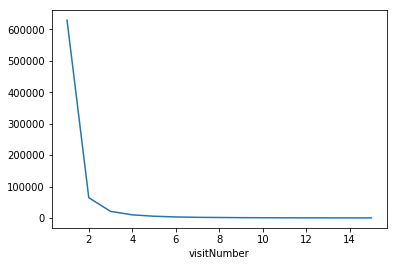

In [12]:
# 누적방문횟수 1회부터 10회까지의 유저 수 분포추이
# 2회 이상 누적방문횟수부터 해당 방문객 수 급감

uniq_visit_total_df.groupby('visitNumber').size()[:15].plot();plt.show()

# 1회만 방문한 방문객의 fullVisitorId (index 데이터타입 저장)
fullVisitorId_onetime = uniq_visit_total_df[uniq_visit_total_df['visitNumber']==1].index

# 2회 이상 방문객의 fullVisitorId (index 데이터타입 저장)
fullVisitorId_over_onetime = uniq_visit_total_df[uniq_visit_total_df['visitNumber']>1].index


### Dictionary 타입 값을 갖는 column 조사

colnames
* device
* geoNetwork
* totals

In [13]:
data['device'][0]

'{"browser": "Chrome", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Windows", "operatingSystemVersion": "not available in demo dataset", "isMobile": false, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "desktop"}'

In [14]:
data['geoNetwork'][0]

'{"continent": "Asia", "subContinent": "Western Asia", "country": "Turkey", "region": "Izmir", "metro": "(not set)", "city": "Izmir", "cityId": "not available in demo dataset", "networkDomain": "ttnet.com.tr", "latitude": "not available in demo dataset", "longitude": "not available in demo dataset", "networkLocation": "not available in demo dataset"}'

In [15]:
data['totals'][0]

'{"visits": "1", "hits": "1", "pageviews": "1", "bounces": "1", "newVisits": "1"}'

#### Dictionary key-value pair가 고정되어 있지 않으므로, 각 칼럼마다 unique key 추출
* 예를 들면, totals 칼럼에서 결제가 발생한 경우에만 'transactionRevenue' 키가 입력되며,
  결제가 일어나지 않은 경우 해당 키가 입력되지 않음
* 데이터셋에 기재되지 않은 정보값은 'not available in demo dataset'으로 입력되며, 이 정보는 배제


In [22]:
import json

def string_to_dict(dict_string):
    # Convert to proper json format
    #dict_string = dict_string.replace("'", '"')
    return json.loads(dict_string)

device_todict = data.device.apply(string_to_dict)
geoNetwork_todict = data.geoNetwork.apply(string_to_dict)
totals_todict = data.totals.apply(string_to_dict)

In [49]:
# 딕셔너리 타입으로 변경한 칼럼 리스트에 대해 유니크 key 추출
dict_cols_to_check = [device_todict, geoNetwork_todict, totals_todict]
dict_names_to_check = ['device', 'geoNetwork', 'totals']

# 키를 저장할 별도의 딕셔너리
todict_keys = {'device' : {},
              'geoNetwork' : {},
              'totals' : {}}


for i, dict_col in enumerate(dict_cols_to_check):
    for dict_ in dict_col:
        for k, v in dict_.items():
            
            # 새로운 키일 경우 리스트에 삽입
            # 키에 대응하는 문자열 값이 "not"으로 시작할 경우 포함하지 않음
            
            if not str(v).startswith('not'):
                if k not in todict_keys[dict_names_to_check[i]].keys():
                    print(i, k, 'inserted.')
                    todict_keys[dict_names_to_check[i]][k] = 1

0 browser inserted.
0 operatingSystem inserted.
0 isMobile inserted.
0 deviceCategory inserted.
1 continent inserted.
1 subContinent inserted.
1 country inserted.
1 region inserted.
1 metro inserted.
1 city inserted.
1 networkDomain inserted.
2 visits inserted.
2 hits inserted.
2 pageviews inserted.
2 bounces inserted.
2 newVisits inserted.
2 transactionRevenue inserted.


In [50]:
todict_keys['device']

{'browser': 1, 'deviceCategory': 1, 'isMobile': 1, 'operatingSystem': 1}

In [51]:
todict_keys['geoNetwork']

{'city': 1,
 'continent': 1,
 'country': 1,
 'metro': 1,
 'networkDomain': 1,
 'region': 1,
 'subContinent': 1}

In [52]:
todict_keys['totals']

{'bounces': 1,
 'hits': 1,
 'newVisits': 1,
 'pageviews': 1,
 'transactionRevenue': 1,
 'visits': 1}

### `device` 칼럼 유효항목
* browser
* operatingSystem
* isMobile
* deviceCategory

### `geoNetwork` 칼럼 유효항목
* continent
* subContinent
* country
* region
* city
* networkDomain
* metro

### `totals ` 유효항목
* bounces
* hits
* newVisits
* pageViews
* transactionRevenue
* visits

### dictionary key-value 값을 데이터프레임에 별도 칼럼으로 복사/생성
* 값이 존재하지 않는 경우 empty string ("")으로 입력

In [70]:
# device 칼럼 
available_device_keys = todict_keys['device'].keys()

device_browser = []
device_operatingSystem = []
device_isMobile = []
device_deviceCategory = []

for dict_ in device_todict:
    new_dict_ = {}
    
    for k, v in dict_.items():
        if k in available_device_keys:
            new_dict_[k] = v
            
    for k in available_device_keys:
        if k not in new_dict_.keys():
            new_dict_[k] = ""
    
    #new_device_todict.append(new_dict_)
    
    device_browser.append(new_dict_['browser'])
    device_operatingSystem.append(new_dict_['operatingSystem'])
    device_isMobile.append(new_dict_['isMobile'])
    device_deviceCategory.append(new_dict_['deviceCategory'])
    

In [73]:
# geoNetwork 칼럼
available_geoNetwork_keys = todict_keys['geoNetwork'].keys()

geoNetwork_continent = []
geoNetwork_subContinent = []
geoNetwork_country = []
geoNetwork_region = []
geoNetwork_city = []
geoNetwork_networkDomain = []
geoNetwork_metro = []

for dict_ in geoNetwork_todict:
    new_dict_ = {}
    
    for k, v in dict_.items():
        if k in available_geoNetwork_keys:
            new_dict_[k] = v
            
    for k in available_geoNetwork_keys:
        if k not in new_dict_.keys():
            new_dict_[k] = ""
    
    geoNetwork_continent.append(new_dict_['continent'])
    geoNetwork_subContinent.append(new_dict_['subContinent'])
    geoNetwork_country.append(new_dict_['country'])
    geoNetwork_region.append(new_dict_['region'])
    geoNetwork_city.append(new_dict_['city'])
    geoNetwork_networkDomain.append(new_dict_['networkDomain'])
    geoNetwork_metro.append(new_dict_['metro'])
    

In [78]:
# totals 칼럼
available_totals_keys = todict_keys['totals'].keys()

totals_bounces = []
totals_hits = []
totals_newVisits = []
totals_pageViews = []
totals_transactionRevenue = []
totals_visits = []

for dict_ in totals_todict:
    new_dict_ = {}
    
    for k, v in dict_.items():
        if k in available_totals_keys:
            new_dict_[k] = v
            
    for k in available_totals_keys:
        if k not in new_dict_.keys():
            new_dict_[k] = '0'
    
    totals_bounces.append(new_dict_['bounces'])
    totals_hits.append(new_dict_['hits'])
    totals_newVisits.append(new_dict_['newVisits'])
    totals_pageViews.append(new_dict_['pageviews'])
    totals_transactionRevenue.append(new_dict_['transactionRevenue'])
    totals_visits.append(new_dict_['visits'])

In [79]:
# 기존 데이터프레임에 신규 칼럼으로 각 정보값을 추가한 신규 데이터프레임 생성.

data_v11 = data.copy()

In [80]:
newcols_names = ['device_browser', 'device_operatingSystem', 'device_isMobile', 'device_deviceCategory',
                'geoNetwork_continent', 'geoNetwork_subContinent', 'geoNetwork_country', 'geoNetwork_region',
                'geoNetwork_city', 'geoNetwork_networkDomain', 'geoNetwork_metro',
                'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageViews',
                'totals_transactionRevenue', 'totals_visits']
newcols_lists = [device_browser, device_operatingSystem, device_isMobile, device_deviceCategory,
                geoNetwork_continent, geoNetwork_subContinent, geoNetwork_country, geoNetwork_region,
                geoNetwork_city, geoNetwork_networkDomain, geoNetwork_metro, totals_bounces,
                totals_hits, totals_newVisits, totals_pageViews, totals_transactionRevenue, totals_visits]

In [81]:
for i, colname in enumerate(newcols_names):
    data_v11[colname] = newcols_lists[i]

data_v11.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,...,geoNetwork_region,geoNetwork_city,geoNetwork_networkDomain,geoNetwork_metro,totals_bounces,totals_hits,totals_newVisits,totals_pageViews,totals_transactionRevenue,totals_visits
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,...,Izmir,Izmir,ttnet.com.tr,(not set),1,1,1,1,0,1
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,...,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,1,1,1,1,0,1
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,...,Community of Madrid,Madrid,unknown.unknown,(not set),1,1,1,1,0,1
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,...,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,1,1,1,1,0,1
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,...,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,1,1,0,1,0,1


In [87]:
data_v11.columns

Index(['channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
       'sessionId', 'socialEngagementType', 'totals', 'trafficSource',
       'visitId', 'visitNumber', 'visitStartTime', 'device_browser',
       'device_operatingSystem', 'device_isMobile', 'device_deviceCategory',
       'geoNetwork_continent', 'geoNetwork_subContinent', 'geoNetwork_country',
       'geoNetwork_region', 'geoNetwork_city', 'geoNetwork_networkDomain',
       'geoNetwork_metro', 'totals_bounces', 'totals_hits', 'totals_newVisits',
       'totals_pageViews', 'totals_transactionRevenue', 'totals_visits'],
      dtype='object')

In [92]:
# device, geoNetwork, totals 기존 칼럼 삭제.
data_v11.drop(['device', 'geoNetwork', 'totals'], axis=1, inplace=True)
data_v11.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,trafficSource,visitId,visitNumber,visitStartTime,device_browser,...,geoNetwork_region,geoNetwork_city,geoNetwork_networkDomain,geoNetwork_metro,totals_bounces,totals_hits,totals_newVisits,totals_pageViews,totals_transactionRevenue,totals_visits
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385,Chrome,...,Izmir,Izmir,ttnet.com.tr,(not set),1,1,1,1,0,1
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147,Firefox,...,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,1,1,1,1,0,1
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386,Chrome,...,Community of Madrid,Madrid,unknown.unknown,(not set),1,1,1,1,0,1
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213,UC Browser,...,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,1,1,1,1,0,1
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600,Chrome,...,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,1,1,0,1,0,1


In [94]:
data_v11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 26 columns):
channelGrouping              903653 non-null object
date                         903653 non-null int64
fullVisitorId                903653 non-null object
sessionId                    903653 non-null object
socialEngagementType         903653 non-null object
trafficSource                903653 non-null object
visitId                      903653 non-null int64
visitNumber                  903653 non-null int64
visitStartTime               903653 non-null int64
device_browser               903653 non-null object
device_operatingSystem       903653 non-null object
device_isMobile              903653 non-null bool
device_deviceCategory        903653 non-null object
geoNetwork_continent         903653 non-null object
geoNetwork_subContinent      903653 non-null object
geoNetwork_country           903653 non-null object
geoNetwork_region            903653 non-null object
geoNetwork_

In [95]:
cols_to_numeric = ['totals_hits', 'totals_newVisits', 'totals_pageViews',
                  'totals_transactionRevenue', 'totals_visits']

for ctn in cols_to_numeric:
    data_v11[ctn] = pd.to_numeric(data_v11[ctn])

In [100]:
data_v11.groupby('fullVisitorId')['totals_transactionRevenue'].sum().sort_values(ascending=False)

fullVisitorId
1957458976293878100    57863790000
1957458976293878100    19249640000
5632276788326171571    16023750000
9417857471295131045    15170120000
4471415710206918415    11211100000
4984366501121503466     8975700000
79204932396995037       7047150000
7496147812697146114     6996500000
9089132392240687728     6387120000
9029794295932939024     6109250000
9026840718082010040     5770790000
5469079519715865124     5601400000
7311242886083854158     5045590000
7284466025557220497     5011560000
7965265156545901045     4847600000
2969957690756250633     4735980000
1814166460229302850     4702890000
7463172420271311409     4417480000
4604965471651937146     4280700000
3769632740374536577     4272000000
9817395183603701442     4085500000
4835082938415020542     4071640000
6236695646664370912     4009560000
6805387544309582877     4007080000
6010250598436085923     3889130000
3244885836845029978     3745370000
2446685875964479851     3740660000
3751433429956400495     3679300000
195630

# Feature Engineering
#### 기존 칼럼을 바탕으로 신규 정보를 추출.

* 몇 번째 방문인지에 대한 정보 칼럼
  * totals_newVisits, totals_visits, date 칼럼으로부터 추출
* 연, 월, 연월에 대한 시간 정보 칼럼
  * date 칼럼으로부터 추출
* 직전 구매시점으로부터 소요된 기간
  * date, totals_transactionRevenue 칼럼으로부터 추출
  

In [2]:
#data_v11.to_csv('data/train_v11.csv')

NameError: name 'data_v11' is not defined

In [3]:
data_v11 = pd.read_csv('data/train_v11.csv')

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data_v11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 27 columns):
Unnamed: 0                   903653 non-null int64
channelGrouping              903653 non-null object
date                         903653 non-null int64
fullVisitorId                903653 non-null object
sessionId                    903653 non-null object
socialEngagementType         903653 non-null object
trafficSource                903653 non-null object
visitId                      903653 non-null int64
visitNumber                  903653 non-null int64
visitStartTime               903653 non-null int64
device_browser               903653 non-null object
device_operatingSystem       903653 non-null object
device_isMobile              903653 non-null bool
device_deviceCategory        903653 non-null object
geoNetwork_continent         903653 non-null object
geoNetwork_subContinent      903653 non-null object
geoNetwork_country           903653 non-null object
geoNetwork_r

#### POSIX 시간(visitStartTime)을 일반 시간으로 변환
* datetime 이용
* POSIX 시간은 UTC 시간 기준으로, date(방문일) 칼럼의 날짜정보와 상이함
  * 접속지역의 시간대 정보를 바탕으로 시차를 적용해야 해당 사용자의 실제 결제 시간대를 파악할 수 있음
  * 국가의 크기가 큰 경우 하나의 국가에서도 시차가 발생하므로, 국가 이상의 지역정보까지 필요시 고려
  * **정보 부족으로 파악불가능함 (도시 등 세부위치정보 부족으로 정확한 시간대 추정 곤란)**
  


In [5]:
data_v11['visitStartTime_conv'] = data_v11.visitStartTime.apply(lambda x: datetime.fromtimestamp(x))                          
data_v11[['visitStartTime','visitStartTime_conv', 'date']].head()

,visitStartTime,visitStartTime_conv,date
0,1472830385,2016-09-03 00:33:05,20160902
1,1472880147,2016-09-03 14:22:27,20160902
2,1472865386,2016-09-03 10:16:26,20160902
3,1472881213,2016-09-03 14:40:13,20160902
4,1472822600,2016-09-02 22:23:20,20160902


In [42]:
data_v11.geoNetwork_region.unique()

array(['Izmir', 'not available in demo dataset', 'Community of Madrid',
       'Queensland', 'Sindh', 'Ile-de-France', '(not set)', 'Buenos Aires',
       'Bangkok', 'Jakarta', 'Karnataka', 'England', 'North Holland',
       'Moscow', 'West Bengal', 'Seoul', 'Santiago Metropolitan Region',
       'Masovian Voivodeship', 'Dublin City', 'Mexico City', 'Catalonia',
       'State of Sao Paulo', 'California', 'Istanbul', 'Dubai', 'Delhi',
       'New South Wales', 'New York', 'State of Rio de Janeiro',
       'Telangana', 'Ontario', 'District of Columbia', 'Maharashtra',
       'Washington', 'Lazio', 'Illinois', 'Massachusetts',
       'Tel Aviv District', 'Lima Region', 'Michigan', 'Taipei City',
       'Texas', 'Pennsylvania', 'Quebec', 'Virginia', 'Ho Chi Minh',
       'Hanoi', 'Nuevo Leon', 'Ankara', 'Metro Manila', 'Budapest',
       'Tokyo', 'British Columbia', 'Kanagawa Prefecture', 'County Dublin',
       'Stockholm County', 'Oregon', 'Colorado', 'Bavaria', 'Tamil Nadu',
       'Kyi

In [31]:
data_v11.geoNetwork_country.unique()

array(['Turkey', 'Australia', 'Spain', 'Indonesia', 'United Kingdom',
       'Italy', 'Pakistan', 'Austria', 'Netherlands', 'India', 'France',
       'Brazil', 'China', 'Singapore', 'Argentina', 'Poland', 'Germany',
       'Canada', 'Thailand', 'Hungary', 'Malaysia', 'Denmark', 'Taiwan',
       'Russia', 'Nigeria', 'Belgium', 'South Korea', 'Chile', 'Ireland',
       'Philippines', 'Greece', 'Mexico', 'Montenegro', 'United States',
       'Bangladesh', 'Japan', 'Slovenia', 'Czechia', 'Sweden',
       'United Arab Emirates', 'Switzerland', 'Portugal', 'Peru',
       'Hong Kong', 'Vietnam', 'Sri Lanka', 'Serbia', 'Norway', 'Romania',
       'Kenya', 'Ukraine', 'Israel', 'Slovakia', '(not set)', 'Lithuania',
       'Puerto Rico', 'Bosnia & Herzegovina', 'Croatia', 'South Africa',
       'Paraguay', 'Botswana', 'Colombia', 'Uruguay', 'Algeria', 'Finland',
       'Guatemala', 'Egypt', 'Malta', 'Bulgaria', 'New Zealand', 'Kuwait',
       'Uzbekistan', 'Saudi Arabia', 'Cyprus', 'Estonia', 'Cô

In [6]:
# 국가명 누락된 정보(null) = 0개
print(data_v11.geoNetwork_country.isnull().sum())

# (not set)으로 표기된 샘플의 갯수 = 
print(data_v11[data_v11.geoNetwork_country == '(not set)'].shape[0])

# 

0
1468


#### 통일된 국가명을 바탕으로 POSIX 방문시간을 해당국가 로컬타임으로 변환

## 국가정보만으로는 로컬타임 정보를 구할 수 없음
## 결제시간(hour/minute)이 아닌, 결제일(day)을 최소시간단위로 데이터 분석 진행요

In [7]:
data_v11.columns

Index(['Unnamed: 0', 'channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'trafficSource', 'visitId', 'visitNumber',
       'visitStartTime', 'device_browser', 'device_operatingSystem',
       'device_isMobile', 'device_deviceCategory', 'geoNetwork_continent',
       'geoNetwork_subContinent', 'geoNetwork_country', 'geoNetwork_region',
       'geoNetwork_city', 'geoNetwork_networkDomain', 'geoNetwork_metro',
       'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageViews',
       'totals_transactionRevenue', 'totals_visits', 'visitStartTime_conv'],
      dtype='object')

## 변수 : `channelGrouping`
Google Analytics 인입채널 명칭 및 의미

![ga-channel-group](https://www.e-nor.com/wp-content/uploads/2015/01/channel-grouping-thumb-1.jpg)

* `Direct` : 직접 주소입력을 통한 인입
* `Organic Search` : 검색엔진 직접 검색을 통한 인입
* `Social` : 소셜미디어 포스팅 링크를 통한 인입
* `Paid Search` : 유료검색 (광고배너 클릭 등)
* `Referral` : 추천 (블로그 포스팅 등)
* `Affiliates` : 제휴사

#### 자연검색(organic search)이 전체 방문객 인입채널의 42%로 최다
* 자연검색 + 소셜미디어 + 직접인입 = 전체의 82%로 대부분을 차지하고 있음
* 추천(Refferals) 통한 인입까지 포함하게 될 경우 90%를 넘게 됨

#### 추천(Referrals)으로 인입한 사용자의 매출발생액이 전체 매출의 42%로 최다
* 매출규모에 따른 Top 3 : 추천, 직접검색, 자연검색 순 (Top 3가 전체의 90% 차지)
* 매출액 관점에서 보았을 때, 추천 마케팅이 가장 큰 효과를 거둔 것으로 나타남.

In [8]:
data_v11.channelGrouping.unique()

array(['Organic Search', 'Referral', 'Paid Search', 'Affiliates', 'Direct',
       'Display', 'Social', '(Other)'], dtype=object)

In [9]:
# 사이트 인입채널별 방문객 수
data_v11.groupby('channelGrouping').count().iloc[:,0].sort_values(ascending=False)

channelGrouping
Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: Unnamed: 0, dtype: int64

In [10]:
# 사이트 인입채널별 샘플 비중
data_v11.groupby('channelGrouping').count().iloc[:,0].sort_values(ascending=False).apply(lambda x: 100*x/data_v11.shape[0])

channelGrouping
Organic Search    42.224283
Social            25.022547
Direct            15.827536
Referral          11.601577
Paid Search        2.802624
Affiliates         1.815188
Display            0.692965
(Other)            0.013279
Name: Unnamed: 0, dtype: float64

In [14]:
# 인입채널 구분에 따른 총 매출규모
data_v11.groupby('channelGrouping')['totals_transactionRevenue'].sum().sort_values(ascending=False)

channelGrouping
Referral          651429910000
Direct            434840550000
Organic Search    326380510000
Display            78337460000
Paid Search        43558900000
Social              4916540000
Affiliates           597380000
(Other)                9990000
Name: totals_transactionRevenue, dtype: int64

In [15]:
# 인입채널 구분에 따른 총 매출규모 비중(%)
data_v11.groupby('channelGrouping')['totals_transactionRevenue'].sum().sort_values(ascending=False).\
                apply(lambda x: x*100/sum(data_v11.totals_transactionRevenue))

channelGrouping
Referral          42.298687
Direct            28.235093
Organic Search    21.192559
Display            5.086613
Paid Search        2.828369
Social             0.319241
Affiliates         0.038789
(Other)            0.000649
Name: totals_transactionRevenue, dtype: float64

In [16]:
data_v11.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,trafficSource,visitId,visitNumber,visitStartTime,...,geoNetwork_city,geoNetwork_networkDomain,geoNetwork_metro,totals_bounces,totals_hits,totals_newVisits,totals_pageViews,totals_transactionRevenue,totals_visits,visitStartTime_conv
0,0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385,...,Izmir,ttnet.com.tr,(not set),1,1,1,1,0,1,2016-09-03 00:33:05
1,1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147,...,not available in demo dataset,dodo.net.au,not available in demo dataset,1,1,1,1,0,1,2016-09-03 14:22:27
2,2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386,...,Madrid,unknown.unknown,(not set),1,1,1,1,0,1,2016-09-03 10:16:26
3,3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213,...,not available in demo dataset,unknown.unknown,not available in demo dataset,1,1,1,1,0,1,2016-09-03 14:40:13
4,4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600,...,not available in demo dataset,unknown.unknown,not available in demo dataset,1,1,0,1,0,1,2016-09-02 22:23:20


In [17]:
# 인입채널 별 결제전환율 (= 각 채널별 결제방문객 숫자 / 전체 방문객)
# 계산의 편의를 위해, 해당 방문에서의 결제여부를 0, 1로 표현하는 칼럼 'totals_has_paid' 생성

data_v11['totals_has_paid'] = data_v11['totals_transactionRevenue'].apply(lambda x: 1 if x>0 else 0)

In [21]:
# 인입채널별 전체 방문객 수
num_visitors_by_channel = data_v11.groupby('channelGrouping')['totals_transactionRevenue'].count()

# 인입채널별 전체 결제사용자 수
num_pu_by_channel = data_v11.groupby('channelGrouping')['totals_has_paid'].sum()

In [27]:
# 인입채널별 결제사용자 전환율 (%)
# 추천(Referral) 통한 사용자의 결제전환율이 5%로 가장 높게 나타났으며
# 자연검색, 제휴사, 소셜미디어, 기타 채널에서는 결제전환율이 1% 미만으로 저조

(num_pu_by_channel / num_visitors_by_channel * 100).sort_values(ascending=False)

channelGrouping
Referral          5.065911
Display           2.267646
Paid Search       1.847903
Direct            1.427712
Organic Search    0.901035
(Other)           0.833333
Affiliates        0.054868
Social            0.045994
dtype: float64

In [30]:
# 인입채널별 인당 평균 결제액

total_rev_by_channel = data_v11.groupby('channelGrouping')['totals_transactionRevenue'].sum()
(total_rev_by_channel / num_pu_by_channel).sort_values(ascending=False)

channelGrouping
Display           5.516723e+08
Direct            2.129484e+08
Referral          1.226567e+08
Organic Search    9.493325e+07
Paid Search       9.307457e+07
Affiliates        6.637556e+07
Social            4.727442e+07
(Other)           9.990000e+06
dtype: float64

## 변수 : `date`
* 연/월/일 단위 매출추이 그래프를 통해, 일정한 파동을 그리는 패턴이 관측됨
* 시즈널 팩터 / 노이즈 등 시계열분석에 대한 검토 필요

In [143]:
data_v11.date

0         20160902
1         20160902
2         20160902
3         20160902
4         20160902
5         20160902
6         20160902
7         20160902
8         20160902
9         20160902
10        20160902
11        20160902
12        20160902
13        20160902
14        20160902
15        20160902
16        20160902
17        20160902
18        20160902
19        20160902
20        20160902
21        20160902
22        20160902
23        20160902
24        20160902
25        20160902
26        20160902
27        20160902
28        20160902
29        20160902
            ...   
903623    20170104
903624    20170104
903625    20170104
903626    20170104
903627    20170104
903628    20170104
903629    20170104
903630    20170104
903631    20170104
903632    20170104
903633    20170104
903634    20170104
903635    20170104
903636    20170104
903637    20170104
903638    20170104
903639    20170104
903640    20170104
903641    20170104
903642    20170104
903643    20170104
903644    20

In [34]:
data_v11['date'] = data_v11['date'].apply(lambda x: str(x))

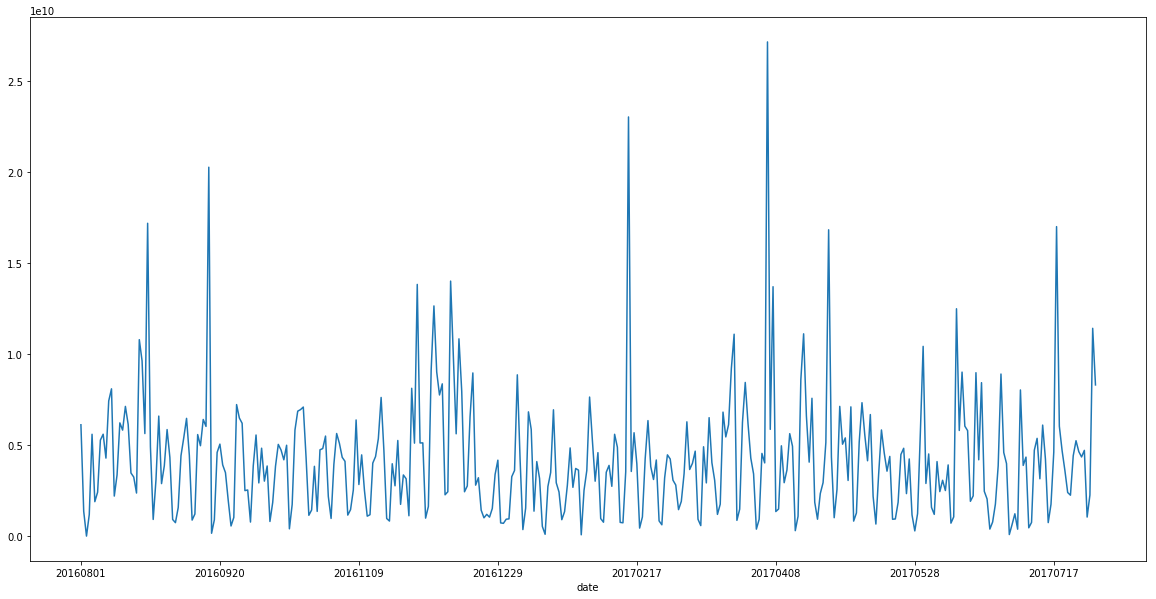

In [169]:
plt.figure(figsize=(20,10))
data_v11.groupby('date')['totals_transactionRevenue'].sum().plot();plt.show()

* 일자별 `신규방문자`, `방문횟수`, `총 페이지뷰`, `클릭 수` 추이
  * (`신규방문자`,`방문횟수`), (`페이지뷰`,`클릭 수`) 각각의 페어는 매우 유사한 양상으로 나타남

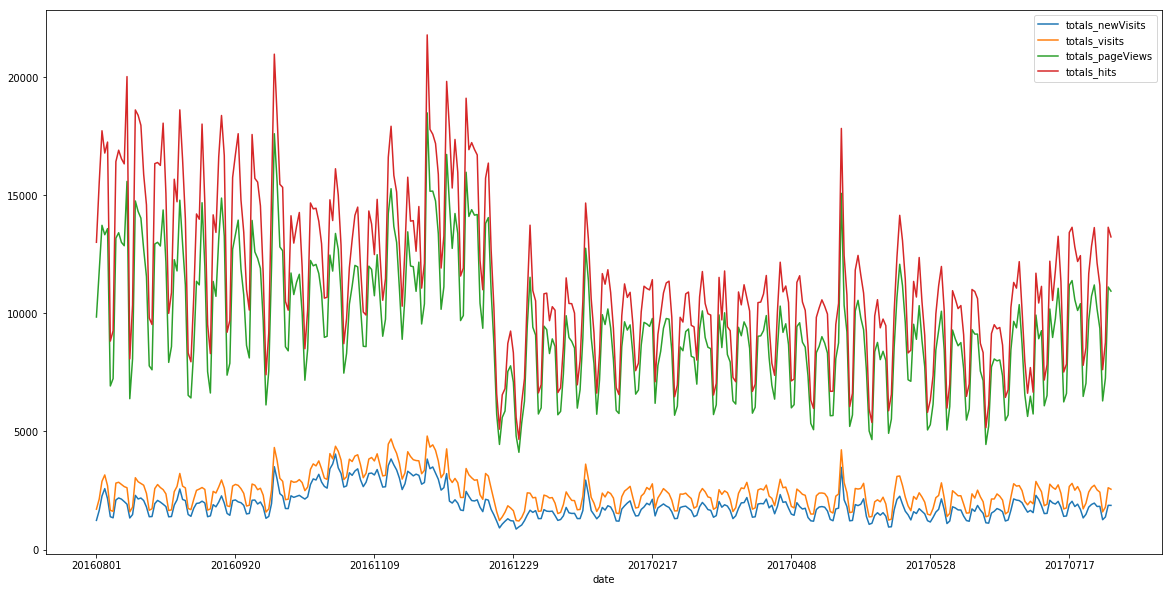

In [35]:
plt.figure(figsize=(20,10))
data_v11.groupby('date')['totals_newVisits'].sum().plot()
data_v11.groupby('date')['totals_visits'].sum().plot()
data_v11.groupby('date')['totals_pageViews'].sum().plot()
data_v11.groupby('date')['totals_hits'].sum().plot()
plt.legend(loc='upper right')
plt.show()

* 매월 최다결제일 계산

In [43]:
data_v11['date_day'] = data_v11.date.apply(lambda x: int(str(x)[6:]))

In [158]:
data_v11['date_day']

array([ 2, 26, 23, 12,  3, 11, 13, 18, 10, 21,  1, 30, 19, 24, 14, 29, 15,
       20, 31, 28,  9, 17, 16, 22,  4,  5, 25,  8, 27,  6,  7])

In [164]:
data_v11.groupby('date_day')['totals_transactionRevenue'].sum()

date_day
1     52716530000
2     37905200000
3     35174580000
4     25254650000
5     80154830000
6     47575870000
7     56116200000
8     44084840000
9     52984780000
10    47099670000
11    35169580000
12    64844560000
13    53656980000
14    69708810000
15    48509820000
16    68033690000
17    53372210000
18    63797430000
19    54276540000
20    52529580000
21    50611780000
22    41242200000
23    44490040000
24    44849540000
25    39778310000
26    42671970000
27    54118750000
28    57519950000
29    37115990000
30    43312840000
31    41393520000
Name: totals_transactionRevenue, dtype: int64

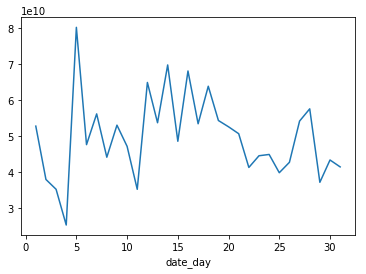

In [165]:
data_v11.groupby('date_day')['totals_transactionRevenue'].sum().plot();plt.show()

* 모든 월에 대한 총계 추이가 아닌, 각월에 대해서도 유사한 패턴이 나오는지에 대한 정보 확인요
  * 각 월에 대해 각각 일자별 매출총계 추이를 하나의 그래프에 표시.
  * **명시적인 패턴이 형성되지 않으며, 계절과 국가별 시즈널 이슈 등의 변수가 포함되는 것으로 판단**

In [39]:
# 이후 계산의 편의를 위하여, date 칼럼의 정보를 월 단위, 연월 단위로 자른 2개의 칼럼 별도 생성
data_v11['date_month'] = data_v11.date.apply(lambda x: int(str(x)[4:6]))
data_v11['date_yearmonth'] = data_v11.date.apply(lambda x: str(x)[:-2])

In [104]:
# 1월 - 12월 
yearmonth_list = ['201608', '201609', '201610', '201611', '201612',
                 '201701', '201702', '201703', '201704', '201705', '201706',
                 '201707', '201708']
yearmonth_rev_by_day = []

for ym in yearmonth_list:
    yearmonth_rev_by_day.append(
            data_v11[data_v11['date_yearmonth'] == ym].groupby('date_day')['totals_transactionRevenue'].sum()
    )

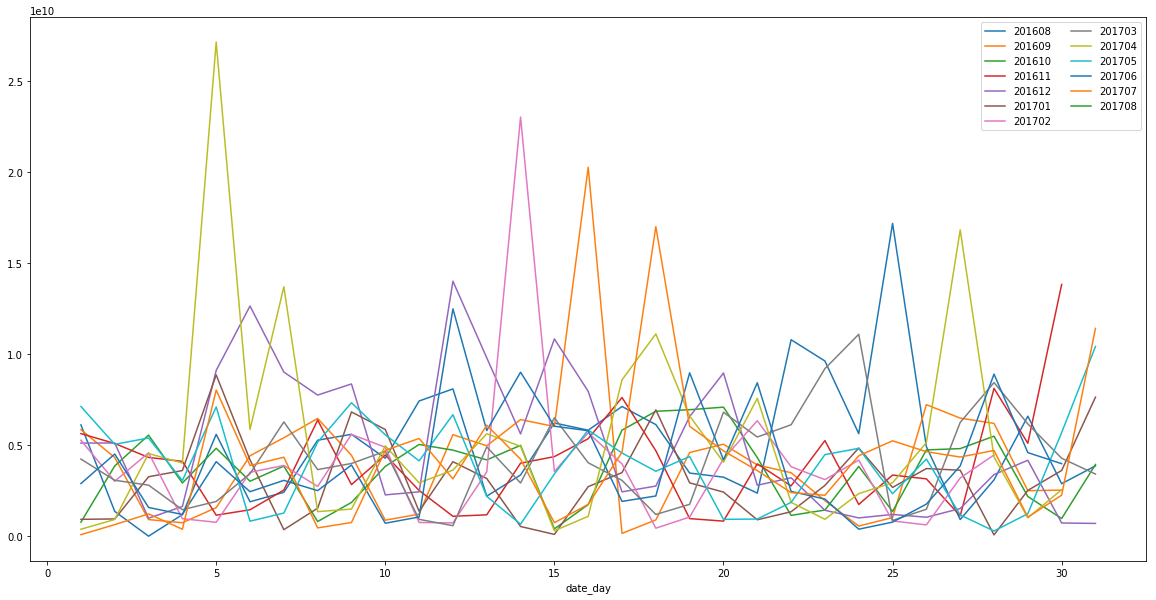

In [106]:
plt.figure(figsize=(20, 10))
for ym_rev in yearmonth_rev_by_day:
    ym_rev.plot()

plt.legend(yearmonth_list, loc='upper right', ncol=2)
plt.show()

* 월별 총매출
  * 4월, 8월, 12월에 매출 그래프가 튀는 모습 확인
  * 그러나 201608-201708 기간의 데이터이므로, **8월 매출은 16년도와 17년도가 함께 잡히는 점 고려**
    * 단, 2017년 8월에 해당하는 샘플은 전체 샘플의 0.2% 수준으로 매우 적은 비중을 차지함을 고려할 때,
    * 월별 중복은 실질적으로 존재하지 않는다고 봐도 무방한 것으로 판단.

In [113]:
data_v11[data_v11['date_yearmonth']=='201708'].count()[0] / data_v11.shape[0] * 100

0.28285193542211445

In [162]:
data_v11.groupby('date_month')['totals_transactionRevenue'].sum()

date_month
1      97877790000
2     108756520000
3     130964270000
4     158788800000
5     121711480000
6     121569490000
7     124499280000
8     162971500000
9     126031240000
10    113329070000
11    119013870000
12    154557930000
Name: totals_transactionRevenue, dtype: int64

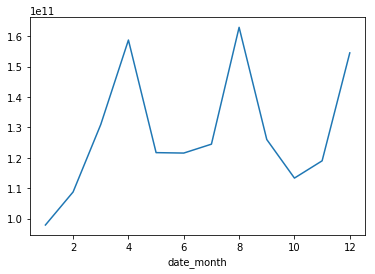

In [40]:
data_v11.groupby('date_month')['totals_transactionRevenue'].sum().plot();plt.show()

* 연/월별 총매출 추이
  * 2017/08 매출데이터는 편향적 시각화 문제로 배제하여 시각화 진행

In [152]:
data_v11.groupby('date_yearmonth')['totals_transactionRevenue'].sum()

date_yearmonth
201608    154666560000
201609    126031240000
201610    113329070000
201611    119013870000
201612    154557930000
201701     97877790000
201702    108756520000
201703    130964270000
201704    158788800000
201705    121711480000
201706    121569490000
201707    124499280000
201708      8304940000
Name: totals_transactionRevenue, dtype: int64

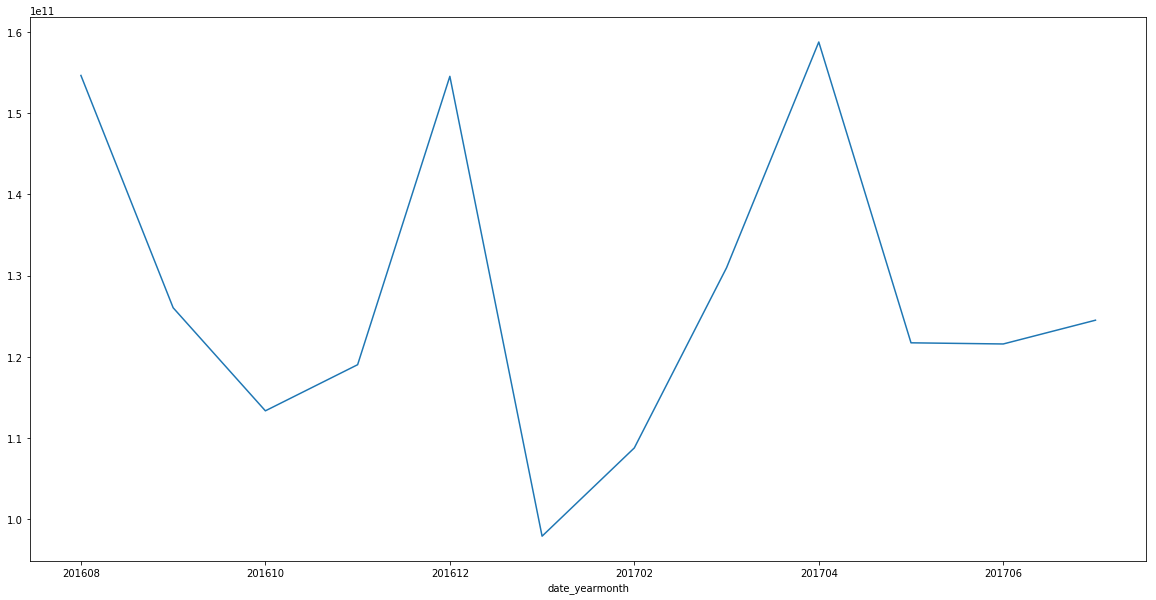

In [114]:
plt.figure(figsize=(20,10))
data_v11.groupby('date_yearmonth')['totals_transactionRevenue'].sum()[:-1].plot()
plt.show()

In [117]:
data_v11.columns

Index(['Unnamed: 0', 'channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'trafficSource', 'visitId', 'visitNumber',
       'visitStartTime', 'device_browser', 'device_operatingSystem',
       'device_isMobile', 'device_deviceCategory', 'geoNetwork_continent',
       'geoNetwork_subContinent', 'geoNetwork_country', 'geoNetwork_region',
       'geoNetwork_city', 'geoNetwork_networkDomain', 'geoNetwork_metro',
       'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageViews',
       'totals_transactionRevenue', 'totals_visits', 'visitStartTime_conv',
       'totals_has_paid', 'date_month', 'date_yearmonth', 'date_day'],
      dtype='object')

## 방문객 식별자 정보
* `fullVisitorId`

In [120]:
# 누적결제액수 TOP 10
top10_customer_by_rev = data_v11.groupby('fullVisitorId')['totals_transactionRevenue'].sum().sort_values(ascending=False)[:10]
top10_customer_by_rev

fullVisitorId
1957458976293878100    75916690000
5632276788326171571    16023750000
9417857471295131045    15170120000
4471415710206918415    11211100000
4984366501121503466     9513900000
9089132392240687728     8951970000
79204932396995037       7047150000
1814166460229302850     7042510000
9029794295932939024     7041060000
7496147812697146114     6996500000
Name: totals_transactionRevenue, dtype: int64

In [128]:
# 누적결제액수 TOP10 사용자의 방문정보만을 추려서 별도 데이터프레임으로 생성
top10_customer_info_li = [data_v11[data_v11['fullVisitorId']==customer_id] for customer_id in top10_customer_by_rev.index]
top10_customer_info_concat = pd.concat(top10_customer_info_li, axis=0)

top10_customer_info_concat.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,trafficSource,visitId,visitNumber,visitStartTime,...,totals_hits,totals_newVisits,totals_pageViews,totals_transactionRevenue,totals_visits,visitStartTime_conv,totals_has_paid,date_month,date_yearmonth,date_day
921,921,Organic Search,20160902,1957458976293878100,1957458976293878100_1472841771,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472841771,85,1472841771,...,22,0,16,0,1,2016-09-03 03:42:51,0,9,201609,2
1645,1645,Organic Search,20160902,1957458976293878100,1957458976293878100_1472821703,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472821703,83,1472821703,...,3,0,3,0,1,2016-09-02 22:08:23,0,9,201609,2
1666,1666,Organic Search,20160902,1957458976293878100,1957458976293878100_1472823804,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472823804,84,1472823804,...,5,0,5,0,1,2016-09-02 22:43:24,0,9,201609,2
4366,4366,Organic Search,20170126,1957458976293878100,1957458976293878100_1485444781,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",1485444781,178,1485444781,...,3,0,3,0,1,2017-01-27 00:33:01,0,1,201701,26
6602,6602,Display,20170623,1957458976293878100,1957458976293878100_1498248064,Not Socially Engaged,"{""campaign"": ""(not set)"", ""source"": ""dfa"", ""me...",1498248064,309,1498248064,...,11,0,11,0,1,2017-06-24 05:01:04,0,6,201706,23


In [136]:
# 유입채널별 분류
# 자연검색 및 직접접근이 

top10_customer_info_concat.groupby('channelGrouping')['channelGrouping'].count().sort_values(ascending=False)

channelGrouping
Organic Search    134
Direct            110
Display            87
Referral           48
Paid Search        11
Name: channelGrouping, dtype: int64

* 신규 유저의 주요 인입채널은?

* 신규 유저의 결제전환율은?

## 네트워크도메인별 점유율
* 90만개 샘플 중, 네트워크도메인의 종류는 총 28000개 수준으로 나타남
* 'not set', 'unknown.unknown' 이 약 40만개 미만 수준으로 전체의 40% 수준
* **변수의 종류가 지나치게 다양하므로, 활동패턴 또는 결제패턴에 따라 군집화 요망**

In [135]:
len(data_v11.geoNetwork_networkDomain.unique())

28064

In [134]:
# 네트워크도메인 상위 10개
data_v11.groupby('geoNetwork_networkDomain').count().iloc[:,0].sort_values(ascending=False)[:10]

geoNetwork_networkDomain
(not set)              244881
unknown.unknown        146034
comcast.net             28743
rr.com                  14827
verizon.net             13637
ttnet.com.tr            13228
comcastbusiness.net      9985
hinet.net                7919
virginm.net              6414
3bb.co.th                6046
Name: Unnamed: 0, dtype: int64

### 시간정보의 활용?
* 유저 집단별 결제기간패턴의 추출
  * 'date' : 연/월 정보
  * 'visitStartTime' : 페이지 접속시간
* The timestamp (expressed as POSIX time) : POSIX
  * 'visitStartTime' - POSIX를 일반 시간으로 변환
  * 결제가 많이 일어나는 시간대 정보 (**파악불가능**)

In [77]:
data.columns

Index(['channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
       'sessionId', 'socialEngagementType', 'totals', 'trafficSource',
       'visitId', 'visitNumber', 'visitStartTime'],
      dtype='object')

In [80]:
data['date'].min(), data['date'].max()

(20160801, 20170801)

In [81]:
data['visitStartTime'].unique()

array([1472830385, 1472880147, 1472865386, ..., 1483526434, 1483592864,
       1483574474])